In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms as T
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
import random
import os
from time import time
from tqdm import tqdm
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 设置随机种子
seed = 42
torch.manual_seed(seed)
random.seed(seed)

cuda


In [2]:
class PascalVOC(torch.utils.data.Dataset):
    """PASCAL VOC 2007 + 2012 数据集"""
    def __init__(self, train=True, image_sizes=None, ratio=1.0):
        super().__init__()
        self.train = train
        self.data07 = torchvision.datasets.VOCDetection(root='../data',
                                                        year='2007',
                                                        image_set='train' if train else 'val',
                                                        download=False)
        self.data12 = torchvision.datasets.VOCDetection(root='../data',
                                                        year='2012',
                                                        image_set='train' if train else 'val',
                                                        download=False)
        if ratio != 1.:
            size07, size12 = int(len(self.data07) * ratio), int(len(self.data12) * ratio)
            self.data07, _ = torch.utils.data.random_split(self.data07, [size07, len(self.data07)-size07])
            self.data12, _ = torch.utils.data.random_split(self.data12, [size12, len(self.data12)-size12])
        self.trans_train = T.Compose([T.ToTensor(),
                                      T.ColorJitter(brightness=0.2,
                                                    contrast=0.2,
                                                    saturation=0.2,
                                                    hue=0.1),
                                      T.Normalize(mean=[0.4541, 0.4336, 0.4016],
                                                   std=[0.2396, 0.2349, 0.2390],)])
        self.trans_valid = T.Compose([T.ToTensor(),
                                      T.Normalize(mean=[0.4541, 0.4336, 0.4016],
                                                   std=[0.2396, 0.2349, 0.2390],)])
        self.cls_labels = ['person',
                           'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
                           'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
                           'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
        if image_sizes is not None:
            self.img_sizes = image_sizes
        else:
            self.img_sizes = [i * 32 + 320 for i in range(10)]
        self.current_shape = None
        self.random_size()
        assert self.current_shape is not None
        
    def __len__(self):
        return len(self.data07) + len(self.data12)
    
    def random_size(self):
        if self.train:
            self.current_shape = self.img_sizes[random.randint(0, len(self.img_sizes) - 1)]
        else:
            self.current_shape = 416
        return self.current_shape
    
    def Resize(self, image, box_coords, size):
        if isinstance(size, (int, float)):
            size = (int(size), int(size))
        h, w = image.size[1], image.size[0]
        resize_ratio = (size[0] / w, size[1] / h)
        image = T.Resize(size)(image)
        box_coords[:, 0::2] = (box_coords[:, 0::2] * resize_ratio[0]).int()
        box_coords[:, 1::2] = (box_coords[:, 1::2] * resize_ratio[1]).int()
        return image, box_coords
    
    def __getitem__(self, index):
        data = self.data07 if index < len(self.data07) else self.data12
        index = index if index < len(self.data07) else index - len(self.data07)
        image = data[index][0]
        box_labels, box_coords = self.get_label_list(data[index][1])
        if self.train:
            image, box_coords = self.Resize(image, box_coords, self.current_shape)
            image, box_coords = self.RandomHorizontalFlip(image, box_coords)
            image = self.trans_train(image)
        else:
            image, box_coords = self.Resize(image, box_coords, 416)
            image = self.trans_valid(image)
        return image, torch.cat((torch.zeros_like(box_labels, dtype=int),
                                    box_labels, box_coords), dim=1)
    
    def get_label_list(self, label):
        obj_list = label['annotation']['object']
        box_labels = [self.cls_labels.index(obj['name'] if type(obj['name']) == str else obj['name'][0]) for obj in obj_list]
        box_coords = []
        for obj in obj_list:
            coord = []
            for k in ['xmin', 'ymin', 'xmax', 'ymax']:
                v = obj['bndbox'][k]
                coord.append(int(v if type(v) == str else v[0]))
            box_coords.append(coord)
        return (torch.tensor(box_labels)[:, None], torch.tensor(box_coords))

    def RandomHorizontalFlip(self, image, box_coords):
        if random.random() > 0.5:
            w = image.size[0]
            image = T.RandomHorizontalFlip(p=1)(image)
            x1, x2 = box_coords[:, 0], box_coords[:, 2]
            box_coords[:, 0], box_coords[:, 2] = w - x2, w - x1
        return image, box_coords
    
    def collate(self, batch):
        image, labels = zip(*batch)
        image = torch.stack(image, 0)
        for i, label in enumerate(labels):
            label[:, 0] = i
        return image, torch.cat(labels, 0)

In [3]:
def inv_sigmoid(x):
    return -torch.log(torch.pow(torch.clamp(x, 1e-6, 1.-1e-6), -1) - 1)

In [30]:
def refine_box(box_cxcywh, shift, downsample_rate=32):
    box = box_cxcywh.to(shift.device)
    p_cx = downsample_rate * (torch.sigmoid(shift[:, 0]) + (box[:, 0] / downsample_rate).floor())
    p_cy = downsample_rate * (torch.sigmoid(shift[:, 1]) + (box[:, 1] / downsample_rate).floor())
    p_w = box[:, 2] * torch.exp(shift[:, 2])
    p_h = box[:, 3] * torch.exp(shift[:, 3])
    return torch.stack([p_cx, p_cy, p_w, p_h], dim=1)

def coord_to_shift(src_cxcywh, tgt_cxcywh, downsample_rate=32):
    assert src_cxcywh.shape == tgt_cxcywh.shape
    t_x = inv_sigmoid(tgt_cxcywh[:, 0] / downsample_rate - (tgt_cxcywh[:, 0] / downsample_rate).floor())
    t_y = inv_sigmoid(tgt_cxcywh[:, 1] / downsample_rate - (tgt_cxcywh[:, 1] / downsample_rate).floor())
    t_w = torch.log(tgt_cxcywh[:, 2] / src_cxcywh[:, 2])
    t_h = torch.log(tgt_cxcywh[:, 3] / src_cxcywh[:, 3])
    return torch.stack([t_x, t_y, t_w, t_h], dim=1)

def cxcywh2xyxy(boxes_cxcywh):
    dim = boxes_cxcywh.dim()
    if dim == 1:
        boxes_cxcywh = boxes_cxcywh.unsqueeze(0)
    boxes_xyxy = torchvision.ops.box_convert(boxes_cxcywh, 'cxcywh', 'xyxy').int()
    if dim == 1:
        boxes_xyxy = boxes_xyxy.squeeze(0)
    return boxes_xyxy
def xyxy2cxcywh(boxes_xyxy):
    dim = boxes_xyxy.dim()
    if dim == 1:
        boxes_xyxy = boxes_xyxy.unsqueeze(0)
    boxes_cxcywh = torchvision.ops.box_convert(boxes_xyxy, 'xyxy', 'cxcywh').int()
    if dim == 1:
        boxes_cxcywh = boxes_cxcywh.squeeze(0)
    return boxes_cxcywh

def freeze(module):
    for param in module.parameters():
        param.requires_grad_(False)
def unfreeze(module):
    for param in module.parameters():
        param.requires_grad_(True)

def batched_nms(boxes, scores, idxs, iou_threshold):
    keep_mask = torch.zeros_like(scores, dtype=torch.bool)
    for class_id in torch.unique(idxs):
        curr_indices = torch.where(idxs == class_id)[0]
        curr_keep_indices = torchvision.ops.nms(boxes[curr_indices], scores[curr_indices], iou_threshold)
        keep_mask[curr_indices[curr_keep_indices]] = True
    keep_indices = torch.where(keep_mask)[0]
    return keep_indices[scores[keep_indices].sort(descending=True)[1]]

def init_weight(module):
    """递归初始化模型参数"""
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(module.weight, std=0.01)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.Sequential, nn.ModuleList)):
        for m in module:
            init_weight(m)

In [46]:
def show_boxes(image, box1=None, box2=None, display=True, scale=2.0):
    if isinstance(image, torch.Tensor):
        if image.dim() == 4:
            image = image.squeeze(0)
        image = image.clone()
        image *= torch.tensor([0.2396, 0.2349, 0.2390], device=image.device).reshape(3, 1, 1)
        image += torch.tensor([0.4541, 0.4336, 0.4016], device=image.device).reshape(3, 1, 1)
        image = T.Resize(int(scale * min(image.shape[-1], image.shape[-2])))(image)
        image = T.ToPILImage()(image)
    image = np.array(image)
    if box2 is not None:
        box2 = (box2 * scale).int()
        for box in box2:
            cv2.rectangle(image,
                          (box[0].item(), box[1].item()),
                          (box[2].item(), box[3].item()),
                          (0, 255, 0), int(2*scale))
    if box1 is not None:
        box1 = (box1 * scale).int()
        for box in box1:
            cv2.rectangle(image,
                          (box[0].item(), box[1].item()),
                          (box[2].item(), box[3].item()),
                          (255, 0, 0), int(1*scale))
            cv2.circle(image,
                       ((box[0].item()+box[2].item())//2,
                        (box[1].item()+box[3].item())//2),
                       int(1*scale), (128, 128, 255), -1)
    if display:
        plt.figure(figsize=(10, 10), dpi=int(60*scale))
        plt.imshow(image)
    return image

In [6]:
def show_predictions(net,
                     data,
                     conf_thres,
                     iou_thres,
                     display=True,
                     scale=2.0):
    """
    给定模型和数据，应用前向传播，得到预测框，并将预测框、对应类别和置信度
    和真实边界框一同显示在图片上。
    """
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    if images.dim() == 3:
        images = images.unsqueeze(0)
    net.eval()
    n = images.shape[0]
    with torch.no_grad():
        preds = net.get_prediction(images,
                                   iou_thres,
                                   conf_thres)
    label_text = ['person',
                  'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
                  'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
                  'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
    results = []
    for i in range(n):
        pred = preds[i]
        pred[:, 2::2] = torch.clamp(pred[:, 2::2], 0, images[i].shape[-1])
        pred[:, 3::2] = torch.clamp(pred[:, 3::2], 0, images[i].shape[-2])
        label = labels[labels[:, 0]==i][:, 2:]
        if pred.shape[0] != 0:
            image = show_boxes(images[i], pred[:, 2:].int(), label, display=False, scale=scale)
        else:
            image = show_boxes(images[i], None, label, display=False, scale=scale)
        for j in range(pred.shape[0]):
            category, confidence = int(pred[j, 0]), pred[j, 1].item()
            text_pos = pred[j, 2:4] * scale
            text_pos[1] -= scale * 2
            text_pos = text_pos.int().cpu().numpy()
            cv2.putText(image, f'{label_text[category]} {confidence:.2f}',
                        text_pos,
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.4 * scale,
                        (255, 0, 0),
                        max(1, round(scale)))
        results.append(image)
    if display:
        for i in range(n):
            plt.figure(figsize=(10, 10), dpi=int(60*scale))
            plt.imshow(results[i])
    return results

In [7]:
class Backbone(nn.Module):
    def __init__(self, backbone_name):
        super().__init__()
        module_dict = {
            'resnet18': (models.resnet18,
                         ['conv1', 'bn1', 'relu', 'maxpool',
                          'layer1', 'layer2'],
                         ['layer3'], ['layer4']),
            'resnet34': (models.resnet34,
                         ['conv1', 'bn1', 'relu', 'maxpool',
                          'layer1', 'layer2'],
                         ['layer3'], ['layer4']),
            'resnet50': (models.resnet50,
                         ['conv1', 'bn1', 'relu', 'maxpool',
                          'layer1', 'layer2'],
                         ['layer3'], ['layer4']),
            'resnet101': (models.resnet101,
                          ['conv1', 'bn1', 'relu', 'maxpool',
                           'layer1', 'layer2'],
                          ['layer3'], ['layer4']),
            'resnet152': (models.resnet152,
                          ['conv1', 'bn1', 'relu', 'maxpool',
                           'layer1', 'layer2'],
                          ['layer3'], ['layer4']),
            'densenet121': (models.densenet121,
                            ['conv0', 'norm0', 'relu0', 'pool0',
                             'denseblock1', 'transition1', 'denseblock2'],
                            ['transition2', 'denseblock3'],
                            ['transition3', 'denseblock4', 'norm5']),
            'densenet161': (models.densenet161,
                            ['conv0', 'norm0', 'relu0', 'pool0',
                             'denseblock1', 'transition1', 'denseblock2'],
                            ['transition2', 'denseblock3'],
                            ['transition3', 'denseblock4', 'norm5']),
            'densenet169': (models.densenet169,
                            ['conv0', 'norm0', 'relu0', 'pool0',
                             'denseblock1', 'transition1', 'denseblock2'],
                            ['transition2', 'denseblock3'],
                            ['transition3', 'denseblock4', 'norm5']),
            'densenet201': (models.densenet201,
                            ['conv0', 'norm0', 'relu0', 'pool0',
                             'denseblock1', 'transition1', 'denseblock2'],
                            ['transition2', 'denseblock3'],
                            ['transition3', 'denseblock4', 'norm5']),
            'mobilenet_v3_small': (models.mobilenet_v3_small,
                                   ['0', '1', '2', '3'],
                                   ['4', '5', '6', '7', '8'],
                                   ['9', '10', '11', '12']),
            'mobilenet_v3_large': (models.mobilenet_v3_large,
                                   ['0', '1', '2', '3', '4', '5', '6'],
                                   ['7', '8', '9', '10', '11', '12'],
                                   ['13', '14', '15', '16'])
        }
        assert backbone_name in list(module_dict.keys())
        raw_backbone = module_dict[backbone_name][0](pretrained=True)._modules
        if backbone_name[:6] != 'resnet':
            raw_backbone = raw_backbone['features']._modules
        self.backbone_ds8  = nn.Sequential(*[raw_backbone[key] for key in module_dict[backbone_name][1]])
        self.backbone_ds16 = nn.Sequential(*[raw_backbone[key] for key in module_dict[backbone_name][2]])
        self.backbone_ds32 = nn.Sequential(*[raw_backbone[key] for key in module_dict[backbone_name][3]])
        
    def forward(self, input):
        fmap_s8 = self.backbone_ds8(input)
        fmap_s16 = self.backbone_ds16(fmap_s8)
        fmap_s32 = self.backbone_ds32(fmap_s16)
        return fmap_s8, fmap_s16, fmap_s32

In [8]:
class Focus(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input):
        assert input.shape[-2] % 2 == 0 and input.shape[-1] % 2 == 0
        reshaped_fmap = torch.cat([input[:, :, i::2, j::2] for i in (0, 1) for j in (0, 1)], dim=1)
        return reshaped_fmap

In [9]:
class SPP(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        y1 = F.max_pool2d(x, kernel_size=5,  stride=1, padding=2)
        y2 = F.max_pool2d(x, kernel_size=9,  stride=1, padding=4)
        y3 = F.max_pool2d(x, kernel_size=13, stride=1, padding=6)
        return torch.cat([x, y1, y2, y3], dim=1)

In [10]:
class CBL(nn.Sequential):
    def __init__(self, in_channels, out_channels=None, k=3, s=1, p=1):
        if out_channels is None:
            out_channels = in_channels
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=k, stride=s, padding=p, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU())

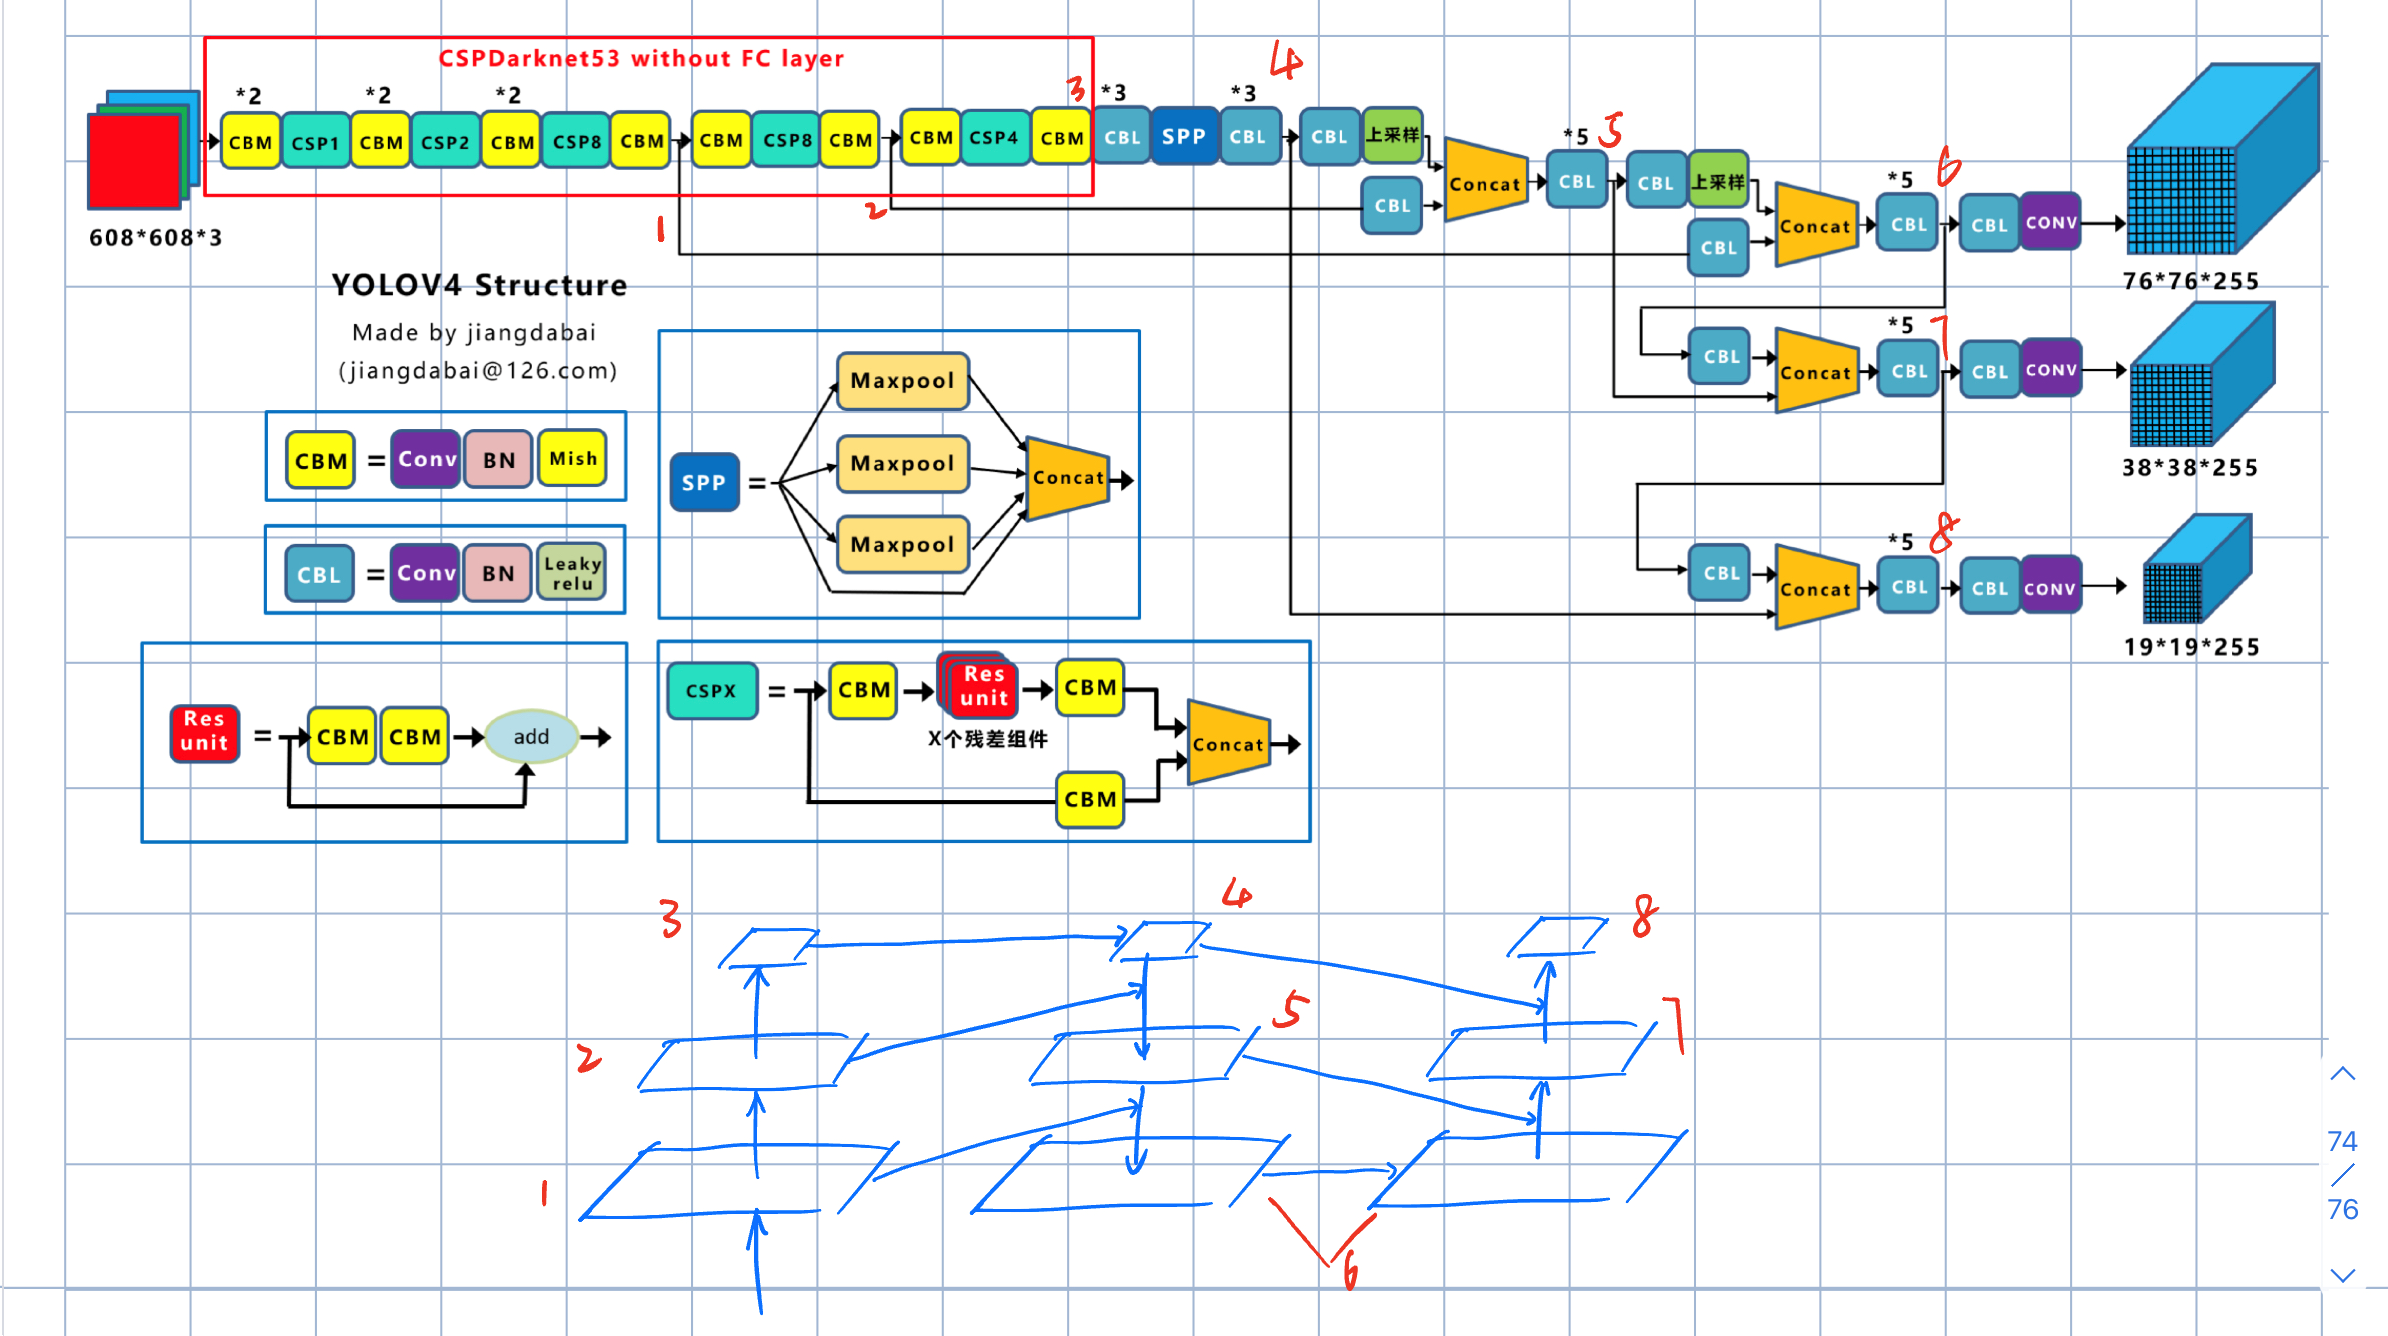

In [11]:
class FPNBlock(nn.Module):
    def __init__(self, small_in_channels, big_in_channels, hidden_layers=5, out_channels=256):
        super().__init__()
        self.small_branch = nn.Sequential(
            CBL(small_in_channels, out_channels),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU())
        self.big_branch = CBL(big_in_channels, out_channels, k=1, s=1, p=0)
        self.merge = [CBL(2 * out_channels, out_channels)]
        for i in range(hidden_layers - 1):
            self.merge.append(CBL(out_channels))
        self.merge = nn.Sequential(*self.merge)
    def forward(self, small, big):
        return self.merge(torch.cat([self.small_branch(small), self.big_branch(big)], dim=1))

In [12]:
class PANBlock(nn.Module):
    def __init__(self, small_in_channels, big_in_channels, hidden_layers=5, out_channels=256):
        super().__init__()
        self.big_branch = CBL(big_in_channels, out_channels, s=2)
        self.merge = [CBL(small_in_channels + out_channels, out_channels)]
        for i in range(hidden_layers - 1):
            self.merge.append(CBL(out_channels))
        self.merge = nn.Sequential(*self.merge)
    def forward(self, small, big):
        return self.merge(torch.cat([small, self.big_branch(big)], dim=1))

In [13]:
class Neck(nn.Module):
    def __init__(self, ds8_outchannels, ds16_outchannels, ds32_outchannels, hidden_layers=5, out_channels=256):
        super().__init__()
        self.trans_3_4 = nn.Sequential(
            CBL(ds32_outchannels, out_channels), CBL(out_channels), CBL(out_channels),
            SPP(),
            CBL(4 * out_channels), CBL(4 * out_channels), CBL(4 * out_channels))
        self.trans_42_5 = FPNBlock(4 * out_channels, ds16_outchannels, hidden_layers, out_channels)
        self.trans_51_6 = FPNBlock(out_channels, ds8_outchannels, hidden_layers, out_channels)
        self.trans_56_7 = PANBlock(out_channels, out_channels, hidden_layers, out_channels)
        self.trans_47_8 = PANBlock(4 * out_channels, out_channels, hidden_layers, out_channels)
    
    def forward(self, input):
        fmap_1, fmap_2, fmap_3 = input
        fmap_4 = self.trans_3_4(fmap_3)
        fmap_5 = self.trans_42_5(fmap_4, fmap_2)
        fmap_6 = self.trans_51_6(fmap_5, fmap_1)
        fmap_7 = self.trans_56_7(fmap_5, fmap_6)
        fmap_8 = self.trans_47_8(fmap_4, fmap_7)
        return fmap_6, fmap_7, fmap_8

In [14]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes, num_anchors, hidden_layers):
        super().__init__()
        out_channels = num_anchors * (5 + num_classes)
        self.head_big, self.head_mid, self.head_sml = [], [], []
        for i in range(hidden_layers):
            self.head_big.append(CBL(in_channels))
            self.head_mid.append(CBL(in_channels))
            self.head_sml.append(CBL(in_channels))
        self.head_big.append(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0))
        self.head_mid.append(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0))
        self.head_sml.append(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0))
        self.head_big = nn.Sequential(*self.head_big)
        self.head_mid = nn.Sequential(*self.head_mid)
        self.head_sml = nn.Sequential(*self.head_sml)
    def forward(self, input):
        fmap_big, fmap_mid, fmap_sml = input
        return self.head_big(fmap_big), self.head_mid(fmap_mid), self.head_sml(fmap_sml)

In [15]:
class Yolo(nn.Module):
    def __init__(self, backbone, anchors, num_classes, hidden_channels, neck_hidden_layers, head_hidden_layers):
        super().__init__()
        self.num_classes = num_classes
        self.num_anchors = len(anchors)
        self.anchor_wh = [anchors[0:len(anchors)//3], anchors[len(anchors)//3:-len(anchors)//3], anchors[-len(anchors)//3:]]
        self.backbone = Backbone(backbone)
        fmap_s8, fmap_s16, fmap_s32 = self.backbone(torch.zeros(1, 3, 64, 64))
        self.neck = Neck(fmap_s8.shape[1], fmap_s16.shape[1], fmap_s32.shape[1], neck_hidden_layers, hidden_channels)
        self.head = Head(hidden_channels, num_classes, len(anchors) // 3, head_hidden_layers)
        init_weight(self.neck)
        init_weight(self.head)
        
    def forward(self, input):
        out_big, out_mid, out_sml = self.head(self.neck(self.backbone(input)))
        objectness, shift, class_conf, anchors_cxcywh = [], [], [], []
        for i, out in enumerate((out_big, out_mid, out_sml)):
            out = out.permute(0, 2, 3, 1)
            n, h, w, c = out.shape
            out = out.reshape(n, h, w, self.num_anchors//3, self.num_classes + 5)
            objectness.append(out[:, :, :, :, 0])
            shift.append(out[:, :, :, :, 1:5])
            class_conf.append(out[:, :, :, :, -self.num_classes:])
            anchors_cxcywh.append(self.generate_anchor((h, w), self.anchor_wh[i], downsample_rate=8*2**i))
        return objectness, shift, class_conf, anchors_cxcywh
        
    def generate_anchor(self, fmap_size, anchor_wh, downsample_rate):
        num_anchors = len(anchor_wh)
        img_h, img_w = fmap_size[-1] * downsample_rate, fmap_size[-2] * downsample_rate
        anchor_wh = torch.tensor([(round(w*img_w), round(h*img_h)) for (w, h) in anchor_wh],
                                 device=device).reshape(1, 1, num_anchors, 2)
        cx = torch.arange(0, fmap_size[-1], 1, device=device).reshape(1, fmap_size[-1], 1, 1) \
           * downsample_rate + downsample_rate // 2
        cy = torch.arange(0, fmap_size[-2], 1, device=device).reshape(fmap_size[-2], 1, 1, 1) \
           * downsample_rate + downsample_rate // 2
        anchor_cxcywh = torch.cat([cx.expand(fmap_size[-2], -1, num_anchors, -1),
                                   cy.expand(-1, fmap_size[-1], num_anchors, -1),
                                   anchor_wh.expand(fmap_size[-2], fmap_size[-1], -1, -1)], dim=-1)
        return anchor_cxcywh
    
    def get_prediction(self, input, iou_thres=0.4, conf_thres=0.5):
        if input.dim() == 3:
            input = input.unsqueeze(0)
        preds = []
        with torch.no_grad():
            objectness, shift, class_conf, anchors_cxcywh = self.forward(input)
        n = input.shape[0]
        num_preds = [0] + [objectness[i].shape[1] * objectness[i].shape[2] * objectness[i].shape[3] for i in range(3)]
        num_preds_accu = [sum(num_preds[:i+1]) for i in range(len(num_preds))]
        objectness = torch.cat([obj.reshape(n, -1).unsqueeze(-1) for obj in objectness], dim=1)
        shift = torch.cat([sft.reshape(n, -1, 4) for sft in shift], dim=1)
        class_conf = torch.cat([cls_conf.reshape(n, -1, self.num_classes) for cls_conf in class_conf], dim=1)
        anchors_cxcywh = torch.cat([anchor.reshape(-1, 4) for anchor in anchors_cxcywh], dim=0)
        class_conf = torch.sigmoid(class_conf) * torch.sigmoid(objectness)
        max_conf, max_idx = class_conf.max(dim=-1)
        for i in range(n):
            mask = max_conf[i] >= conf_thres
            pred_xyxy = []
            for j in range(3):
                idx = torch.arange(0, sum(num_preds), 1, device=device)
                head_mask = (idx >= num_preds_accu[j]) & (idx < num_preds_accu[j+1]) & mask
                pred_xyxy.append(cxcywh2xyxy(refine_box(anchors_cxcywh[head_mask], shift[i, head_mask], 8*2**j)))
            pred_xyxy = torch.cat(pred_xyxy, dim=0)
            remains = batched_nms(pred_xyxy.float(), max_conf[i, mask], max_idx[i, mask], iou_thres)
            pred_xyxy = pred_xyxy[remains]
            remains = torch.where(mask)[0][remains]
            pred_conf, pred_idx = max_conf[i, remains], max_idx[i, remains]
            pred = torch.cat([pred_idx[:, None], pred_conf[:, None], pred_xyxy], dim=-1)
            preds.append(pred)
        return preds

In [16]:
class ComputeLoss:
    def __init__(self,
                 obj_pos_weight,
                 num_classes,
                 obj_gain,
                 cls_gain,
                 reg_gain,
                 neg_thres,
                 obj_pos_ratio):
        self.num_classes = num_classes
        if isinstance(obj_pos_weight, (int, float)):
            obj_pos_weight = torch.tensor(obj_pos_weight, device=device).float()
        self.criterion_obj = nn.BCEWithLogitsLoss(pos_weight=obj_pos_weight)
        self.criterion_cls = nn.BCEWithLogitsLoss()
        # self.criterion_cls = nn.CrossEntropyLoss(weight=cls_weight)
        # self.criterion_reg = nn.SmoothL1Loss()
        self.criterion_reg = torchvision.ops.complete_box_iou_loss
        
        self.obj_gain = obj_gain
        self.cls_gain = cls_gain
        self.reg_gain = reg_gain
        self.neg_thres = neg_thres
        self.obj_pos_ratio = obj_pos_ratio
        
    def __call__(self, preds, labels):
        (reg_outputs, reg_targets), (obj_outputs, obj_targets), (cls_outputs, cls_targets), responsible_anchors = \
            self.build_target(preds, labels)
        loss_obj = self.criterion_obj(obj_outputs, obj_targets)
        loss_cls = self.criterion_cls(cls_outputs, F.one_hot(cls_targets, self.num_classes).float())
        # loss_cls = self.criterion_cls(cls_outputs, cls_targets)
        # loss_reg = self.criterion_reg(reg_outputs, reg_targets)
        loss_reg = self.criterion_reg(reg_outputs, reg_targets, reduction='mean')
        loss = self.obj_gain * loss_obj + \
               self.cls_gain * loss_cls + \
               self.reg_gain * loss_reg
        return loss_obj.item(), loss_cls.item(), loss_reg.item(), loss
        
    def build_target(self, preds, labels):
        objectness, shift, class_conf, anchors_cxcywh = preds
        n = objectness[0].shape[0]
        pos_table = [torch.zeros_like(objectness[i], device=labels.device, dtype=bool) for i in range(3)]
        neg_table = [torch.ones_like(objectness[i], device=labels.device, dtype=bool) for i in range(3)]
        obj_outputs, obj_targets = [], []
        reg_outputs, reg_targets = [], []
        cls_outputs, cls_targets = [], []
        responsible_anchors = []
        # 负样本
        for i in range(n):
            for j in range(3):
                gt_xyxy = labels[labels[:, 0]==i][:, 2:]
                h, w, c = anchors_cxcywh[j].shape[:3]
                pred_cxcywh = refine_box(anchors_cxcywh[j].reshape(-1, 4), shift[j][i].reshape(-1, 4), 8*2**j)
                pred_xyxy = cxcywh2xyxy(pred_cxcywh)
                pred_gt_iou = torchvision.ops.box_iou(pred_xyxy, gt_xyxy).reshape(h, w, c, gt_xyxy.shape[0])
                max_values, _ = pred_gt_iou.max(dim=-1)
                neg_table[j][i] = max_values < self.neg_thres
        # 正样本，遍历所有真实边界框
        for label in labels:
            if label.dim() == 2:
                label = label.squeeze(0)
            sample_idx, category, gt_xyxy = label[0], label[1].reshape(-1), label[None, 2:]
            gt_cxcywh = xyxy2cxcywh(gt_xyxy)
            corresponding_anchors_cxcywh = []
            for j in range(3):
                # 当前真实边界框的中心点所在的网格
                gt_cx = int((gt_cxcywh[0, 0] / (8*2**j)).floor().item())
                gt_cy = int((gt_cxcywh[0, 1] / (8*2**j)).floor().item())
                # 网络在当前真实边界框的中心点所在网格预测的预测框
                corresponding_anchors_cxcywh.append(anchors_cxcywh[j][gt_cy, gt_cx])
            corresponding_anchors_cxcywh = torch.cat(corresponding_anchors_cxcywh, dim=0)
            corresponding_anchors_xyxy = cxcywh2xyxy(corresponding_anchors_cxcywh)
            
            # 找出与真实边界框IOU最高的锚框
            gt_anchor_iou = torchvision.ops.box_iou(gt_xyxy,
                                                    corresponding_anchors_xyxy).squeeze(0)
            idx = int(gt_anchor_iou.argmax())
            head_idx, anchor_idx = idx//(anchors_cxcywh[0].shape[2]), idx%(anchors_cxcywh[0].shape[2])
            gt_cx = int((gt_cxcywh[0, 0] / (8*2**head_idx)).floor().item())
            gt_cy = int((gt_cxcywh[0, 1] / (8*2**head_idx)).floor().item())
            # 防止一个anchor被重复选中
            while pos_table[head_idx][sample_idx, gt_cy, gt_cx, anchor_idx]:
                gt_anchor_iou[idx] = -1.
                idx = int(gt_anchor_iou.argmax())
                head_idx, anchor_idx = idx//(anchors_cxcywh[0].shape[2]), idx%(anchors_cxcywh[0].shape[2])
                gt_cx = int((gt_cxcywh[0, 0] / (8*2**head_idx)).floor().item())
                gt_cy = int((gt_cxcywh[0, 1] / (8*2**head_idx)).floor().item())
                if gt_anchor_iou.max() < 0:
                    break
            if gt_anchor_iou.max() < 0:
                continue
            responsible_anchor = corresponding_anchors_cxcywh[None, idx]
            reg_target = gt_xyxy.float()
            reg_output = torchvision.ops.box_convert(
                refine_box(responsible_anchor,
                           shift[head_idx][sample_idx, gt_cy, gt_cx, anchor_idx][None, :],
                           downsample_rate=8*2**head_idx),
                'cxcywh', 'xyxy')
            # reg_target = coord_to_shift(responsible_anchor, gt_cxcywh, downsample_rate=8*2**head_idx)
            # reg_output = shift[head_idx][None, sample_idx, gt_cy, gt_cx, anchor_idx]
            cls_output = class_conf[head_idx][sample_idx, gt_cy, gt_cx, anchor_idx]
            obj_output = objectness[head_idx][sample_idx, gt_cy, gt_cx, anchor_idx].reshape(-1)
            reg_outputs.append(reg_output)
            reg_targets.append(reg_target)
            obj_outputs.append(obj_output)
            obj_targets.append(torch.ones_like(obj_output))
            cls_outputs.append(cls_output)
            cls_targets.append(category)
            responsible_anchors.append(responsible_anchor)
            
            pos_table[head_idx][sample_idx, gt_cy, gt_cx, anchor_idx] = True
            neg_table[head_idx][sample_idx, gt_cy, gt_cx, anchor_idx] = False
        
        num_pos_samples = sum([pos_table[i].sum() for i in range(3)])
        num_neg_samples = int(((1-self.obj_pos_ratio) / self.obj_pos_ratio) * num_pos_samples)
        obj_output = torch.cat([objectness[i][neg_table[i]] for i in range(3)])
        mask = torch.rand_like(obj_output) < float(num_neg_samples/obj_output.shape[0])
        obj_output = obj_output[mask]
        obj_outputs.append(obj_output)
        obj_targets.append(torch.zeros_like(obj_output))
        
        assert all(((pos_table[i] & neg_table[i]).sum().item() == 0 for i in range(3)))
        reg_outputs, reg_targets = torch.cat(reg_outputs, dim=0), torch.cat(reg_targets, dim=0)
        obj_outputs, obj_targets = torch.cat(obj_outputs, dim=0), torch.cat(obj_targets, dim=0)
        cls_outputs, cls_targets = torch.stack(cls_outputs, dim=0), torch.cat(cls_targets, dim=0)
        num_pos_samples = cls_targets.shape[0]
        obj_outputs = obj_outputs[:int(num_pos_samples / self.obj_pos_ratio)]
        obj_targets = obj_targets[:int(num_pos_samples / self.obj_pos_ratio)]
        return (reg_outputs, reg_targets), (obj_outputs, obj_targets),\
               (cls_outputs, cls_targets), torch.cat(responsible_anchors, dim=0)

In [17]:
def train_yolo_one_step(net, data, criterion, optimizer):
    image, labels = data
    image, labels = image.to(device), labels.to(device)
    preds = net(image)
    loss_obj, loss_cls, loss_reg, loss = criterion(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss_obj, loss_cls, loss_reg, loss.item()

In [18]:
def warmup_lr_ratio(warmup_steps, cur_step, power=1.):
    if cur_step == 0:
        return 0
    lr_ratio = min(cur_step ** -power,
                   (cur_step * warmup_steps ** -(1.+power))) * warmup_steps ** power
    return lr_ratio

In [19]:
def get_lr(optimizer):
    return (optimizer.state_dict()['param_groups'][0]['lr'])

In [20]:
def train_yolo(net, cfg):
    voc_train = PascalVOC(train=True, image_sizes=cfg.image_sizes, ratio=cfg.data_ratio)
    dataloader = torch.utils.data.DataLoader(voc_train,
                                             batch_size=cfg.batch_size,
                                             collate_fn=voc_train.collate,
                                             shuffle=True,
                                             num_workers=cfg.num_workers)
    num_batches = len(dataloader)
    criterion = ComputeLoss(cfg.obj_pos_weight,
                            cfg.num_classes,
                            cfg.obj_gain,
                            cfg.cls_gain,
                            cfg.reg_gain,
                            cfg.neg_thres,
                            cfg.obj_pos_ratio)
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=cfg.lr,
                                weight_decay=cfg.weight_decay,
                                momentum=0.9)
    warmup_lr = lambda cur_step: warmup_lr_ratio(int(cfg.warmup_steps*cfg.num_epochs*num_batches),
                                                 cur_step, cfg.lr_decay_power)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lr)
    writer = SummaryWriter(log_dir=f'runs/{cfg.version}')
    net.train()
    global_step = 0
    for epoch in range(1, cfg.num_epochs+1):
        epoch_loss = []
        pbar = tqdm(enumerate(dataloader), total=num_batches)
        for i, data in pbar:
            pbar.set_description(f"epoch {epoch:3d}")
            loss_obj, loss_cls, loss_reg, loss = train_yolo_one_step(net, data, criterion, optimizer)
            scheduler.step()
            global_step += 1
            pbar.set_postfix(obj=f"{loss_obj:.4f}", cls=f"{loss_cls:.4f}", reg=f"{loss_reg:.4f}", loss=f"{loss:.4f}")
            if global_step % 10 == 0:
                voc_train.random_size()
                writer.add_scalars('train/loss', {'reg': loss_reg, 
                                                  'cls': loss_cls,
                                                  'obj': loss_obj,
                                                  'weighted sum': loss}, global_step=global_step)
                writer.add_scalar('train/lr', get_lr(optimizer), global_step=global_step)
            epoch_loss.append(loss)
            if global_step % (num_batches // 5) == 0:
                net.eval()
                with torch.no_grad():
                    data = (data[0][0][None, :], data[1][data[1][:, 0]==0])
                    infer_result = show_predictions(net,
                                                    data,
                                                    conf_thres=0.5,
                                                    iou_thres=0.2,
                                                    display=False,
                                                    scale=2.0)
                net.train()
                writer.add_image('train/images_with_predictions',
                                 infer_result[0],
                                 global_step=global_step,
                                 dataformats='HWC')
        print(f'epoch {epoch:4d}, loss={sum(epoch_loss) / len(epoch_loss):8.4f}')
        torch.save(net.backbone.state_dict(), f'models/{cfg.version}_backbone.pth')
        torch.save(net.neck.state_dict(), f'models/{cfg.version}_neck.pth')
        torch.save(net.head.state_dict(), f'models/{cfg.version}_head.pth')

In [21]:
class Configuration:
    def __init__(self):
        self.version = 'version 9'
        self.backbone = 'mobilenet_v3_large'
        self.num_classes = 20
        self.neck_hidden_layers = 1
        self.head_hidden_layers = 4
        self.hidden_channels = 64
        self.neg_thres = 0.3
        
        self.data_ratio = 1.0
        self.anchors = [(0.07, 0.14), (0.1, 0.1), (0.14, 0.07),
                        (0.274, 0.548), (0.387, 0.387), (0.548, 0.274),
                        (0.5, 1.0), (0.8, 0.8), (1.0, 0.5)]
        self.image_sizes = [i * 32 + 320 for i in range(10)]
        self.obj_pos_weight = 7.
        self.obj_pos_ratio = 0.05
        self.obj_gain = 1.
        self.cls_gain = 3.
        self.reg_gain = 1.5
        
        self.lr = 1e-2
        self.warmup_steps = 0.05
        self.lr_decay_power = 0.7
        self.batch_size = 16
        self.num_epochs = 50
        self.weight_decay = 2e-4
        self.num_workers = 8

In [22]:
cfg = Configuration()

In [23]:
yolo = Yolo(cfg.backbone,
            cfg.anchors,
            cfg.num_classes,
            cfg.hidden_channels,
            cfg.neck_hidden_layers,
            cfg.head_hidden_layers).to(device)
# print(yolo.neck)
# print(yolo.head)

/home/zxh0916/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/zxh0916/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# train_yolo(yolo, cfg)

In [25]:
yolo.backbone.load_state_dict(torch.load(f'models/{cfg.version}_backbone.pth'))
yolo.neck.load_state_dict(torch.load(f'models/{cfg.version}_neck.pth'))
yolo.head.load_state_dict(torch.load(f'models/{cfg.version}_head.pth'))

<All keys matched successfully>

In [26]:
# voc_train = PascalVOC(train=True, image_sizes=cfg.image_sizes)
# dataloader = torch.utils.data.DataLoader(voc_train,
#                                          batch_size=1,
#                                          collate_fn=collate,
#                                          shuffle=True,
#                                          num_workers=cfg.num_workers)
# print(len(dataloader))
# criterion = ComputeLoss(cfg.obj_pos_weight,
#                         cfg.num_classes,
#                         cfg.obj_gain,
#                         cfg.cls_gain,
#                         cfg.reg_gain,
#                         cfg.neg_thres)
# for image, labels in dataloader:
#     image, labels = image.to(device), labels.to(device)
#     preds = yolo(image)
#     (reg_outputs, reg_targets), (obj_outputs, obj_targets), (cls_outputs, cls_targets), responsible_anchors = \
#         criterion.build_target(preds, labels)
#     _ = show_boxes(image, cxcywh2xyxy(responsible_anchors), labels[:, 2:], scale=1.0)
#     _ = show_boxes(image, reg_outputs, labels[:, 2:], scale=1.0)
#     print(obj_outputs[obj_targets!=0])
#     print(reg_targets)
#     for i in range(cls_outputs.shape[0]):
#         print(cls_outputs[i][cls_targets[i]])
#     break

In [27]:
from tqdm import tqdm
tic = time()
voc_dataset = PascalVOC(False)
voc_dataset.current_shape = 416
yolo.eval()
for i in tqdm(range(len(voc_dataset))):
    data = voc_dataset[i]
    img = show_predictions(yolo,
                           data,
                           conf_thres=0.6,
                           iou_thres=0.3,
                           display=False,
                           scale=2.0)
    plt.imsave(f'./outputs/{cfg.version}/{i}.jpg', img[0])
print((time() - tic) / len(voc_dataset))

100%|███████████████████████████████████████| 8333/8333 [08:20<00:00, 16.66it/s]

0.06001317908780194


In [29]:
from tqdm import tqdm
tic = time()
voc_dataset = PascalVOC(False)
voc_dataset.current_shape = 608
yolo.eval()
for i in tqdm(range(len(voc_dataset))):
    data = voc_dataset[i]
    img = show_predictions(yolo,
                           data,
                           conf_thres=0.8,
                           iou_thres=0.2,
                           display=False,
                           scale=2.0)
    plt.imsave(f'./outputs/{cfg.version}_largescale/{i}.jpg', img[0])
print((time() - tic) / len(voc_dataset))

100%|███████████████████████████████████████| 8333/8333 [08:10<00:00, 17.00it/s]

0.05882946632066638
